<a href="https://colab.research.google.com/github/celinascaglione/trabajos/blob/main/tpcodo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de librerias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#evitar uso de notacion cientifica
pd.options.display.float_format = '{:.2f}'.format

#Obtención de datos

In [ ]:
#listas con IDs y nombre del sheet para importar iterando.
ID_plantillas = ["1hsJkHRC3MbDBzVvyMR5sanmaEuI-wOIg",
                 "12ZTuvzztLbcgLsYmoyM2fZ9XfwGqkmIQJMOPS0eX3L8",
                 "11RLT7rJOZwIEO0oTlnUZI7rVyeoPqsuCY9v31H9F4i0",
                 "1ZhAuIacEYP-zLzi3ULutBkn5-uJRB4j0JJ8xBr9AeaI"]
sheet_names = ["sales_in_Paraguay", "distributors_profiles", "exports_to_Paraguay", "locations_profiles"]

#lista para los distintos data frames
dataframes = {}

#iteracion para cargar archivos y guardar los dataframes
for file_id, sheet_name in zip(ID_plantillas, sheet_names):
    print(f"https://docs.google.com/spreadsheets/d/{file_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}")
    URL = f"https://docs.google.com/spreadsheets/d/{file_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    dataframes[sheet_name] = pd.read_csv(URL, thousands = ".")


https://docs.google.com/spreadsheets/d/1hsJkHRC3MbDBzVvyMR5sanmaEuI-wOIg/gviz/tq?tqx=out:csv&sheet=sales_in_Paraguay
https://docs.google.com/spreadsheets/d/12ZTuvzztLbcgLsYmoyM2fZ9XfwGqkmIQJMOPS0eX3L8/gviz/tq?tqx=out:csv&sheet=distributors_profiles
https://docs.google.com/spreadsheets/d/11RLT7rJOZwIEO0oTlnUZI7rVyeoPqsuCY9v31H9F4i0/gviz/tq?tqx=out:csv&sheet=exports_to_Paraguay
https://docs.google.com/spreadsheets/d/1ZhAuIacEYP-zLzi3ULutBkn5-uJRB4j0JJ8xBr9AeaI/gviz/tq?tqx=out:csv&sheet=locations_profiles


#Exploración de los datos

In [ ]:
#mostrar dataframes y types
for sheet_name, df in dataframes.items():
  print(f"Dataframe: {sheet_name}")
  print(df.dtypes)
  print(f"Filas: {len(df)}")
  display(df.head())


NameError: name 'dataframes' is not defined

Se ve que los IDs y distributors son floats y deberian ser ints, los valores monetarios son objects en vez de floats, y que hay valores NaN. Tambien hay columnas de datos basura, al igual que una hilera de totales en uno de los archivos.

In [ ]:
#diccionario de columnas a convertir en int por tabla una vez se realize la limpieza
columns_to_int ={
    "sales_in_Paraguay": [],
    "distributors_profiles": ["id"],
    "exports_to_Paraguay": [],
    "locations_profiles": ["id"]}
#diccionario de columnas a dropear una vez se realize la limpieza
columns_to_drop ={
    "sales_in_Paraguay": ["distributor"],
    "distributors_profiles": ["distributor activities"],
    "exports_to_Paraguay": ["Columnas"],
    "locations_profiles": ["PYid", "location"]}
#filas a dropear al final del dataframe
rows_to_drop ={
    "sales_in_Paraguay": 1}



La razon para dropear en la limpieza dichas columnas en cada diccionario son:
- Ninguna, pues todos los datos serviran para el analisis al comparar las ventas de brick y steel con las demas
- Distributor activities no ees relevante
- Ninguna, pues todos los datos serviran para el analisis al comparar las exportaciones a uruguay de los distintos materiales. Las columnas invalidas se cortaran de otra forma.
- PYid y location no brindan informacion esencial. Department se deja a cambio de location pues es más representativo de la produccion nacional y más util en caso de realizar un grafico de mapa.


#Limpieza de Datos "General"


In [ ]:
# iterar sobre cada tabla para convertir en int, eliminar NaN, transformar moneda a float, y eliminar columnas/filas innecesarias
for df in dataframes:

  print(df)

  #eliminar duplicados en los dataframes
  num_duplicates_before = dataframes[df].duplicated().sum()
  dataframes[df].drop_duplicates(inplace=True)
  print(f"Duplicados: {num_duplicates_before}")

  #eliminar ultimas filas segun el numero y dataframe especificado
  if df in rows_to_drop:
    dataframes[df] =  dataframes[df].iloc[:, :13]

  #droppear columnas a dropear, al igual que las que no tengan nombre
  dataframes[df] = dataframes[df].loc[:, ~dataframes[df].columns.str.contains("^Unnamed")]
  dataframes[df] = dataframes[df].drop(columns=columns_to_drop[df])

  # queremos poder ver la actividad de las ubicaciones sin distribuidores. Por lo tanto, reemplazaremos los NaNs con "0" en la columna de id.
  # esto permitirá limpiar los NaNs reales en este y otros dataframes sin eliminar estos registros.
  if df == "locations_profiles":
    dataframes[df]["id"] = dataframes[df]["id"].fillna(0).astype(int)

  # eliminar NaNs y contar
  print(f"NaNs encontrados: {dataframes[df].isnull().sum().sum()}")
  rows_before = dataframes[df].shape[0]
  dataframes[df].dropna(inplace=True)
  rows_after = dataframes[df].shape[0]
  rows_dropped = rows_before - rows_after


  # convertir columnas especificadas a int
  if df in columns_to_int:
    for col in columns_to_int[df]:
        if col in dataframes[df].columns:
            dataframes[df][col] = pd.to_numeric(dataframes[df][col], errors="coerce").fillna(0).astype(int)

  # Convertir columnas monetarias a float
  for col in dataframes[df].columns:
      if dataframes[df][col].dtype == object:
          try:
              dataframes[df][col] = dataframes[df][col].apply(lambda x: float(x.replace("$", "").replace(".", "").replace(",", ".")))
          except ValueError:
              pass  # si no se puede convertir a monetario, es string. Pasar.

#dataframes tras limpieza
for sheet_name, df in dataframes.items():
  print(f"Dataframe: {sheet_name}")
  print(df.dtypes)
  print(f"Numero de filas: {len(df)}")
  display(df.head())



sales_in_Paraguay
Duplicados: 0
NaNs encontrados: 0
distributors_profiles
Duplicados: 1
NaNs encontrados: 2
exports_to_Paraguay
Duplicados: 2
NaNs encontrados: 0
locations_profiles
Duplicados: 0
NaNs encontrados: 2
Dataframe: sales_in_Paraguay
Rubber        float64
Brass         float64
Vinyl         float64
Granite       float64
Stone         float64
Brick         float64
Aluminum      float64
Glass         float64
Plexiglass    float64
Steel         float64
Wood          float64
Plastic       float64
dtype: object
Numero de filas: 45


,Rubber,Brass,Vinyl,Granite,Stone,Brick,Aluminum,Glass,Plexiglass,Steel,Wood,Plastic
0,54510203.61,45268636.86,51579748.25,21780180.58,26576776.52,0.00,55872547.77,18050385.12,178927599.01,2788.80,54510203.61,20982.80
1,32438788.20,25837100.49,36603264.50,21883374.92,1473437.08,0.00,46239695.30,33102840.61,35563624.11,599.01,9945371.16,187306.41
2,21780180.58,78927599.01,25837100.49,33102840.61,51579748.25,0.00,21883374.92,78927599.01,1346769.34,0.00,36603264.50,300838.58
3,79358855.35,90185311.22,45268636.86,54510203.61,59358855.35,0.00,79358855.35,32067534.68,53172624.14,2922.94,33102840.61,579748.25
4,11758005.07,21780180.58,57187306.41,9945371.16,32067534.68,0.00,53172624.14,57187306.41,1155872547.77,203.61,43512922.94,730734.07


Dataframe: distributors_profiles
id                                   int64
distributor                         object
years in the construction market     int64
dtype: object
Numero de filas: 44


,id,distributor,years in the construction market
0,565,Abernathy-Hayes,15
1,1384,Balistreri LLC,22
2,1183,Brekke-Stiedemann,13
3,1526,Collins LLC,12
4,29,Cummings-Ward,23


Dataframe: exports_to_Paraguay
distributor      int64
Rubber         float64
Brass          float64
Vinyl          float64
Granite        float64
Stone          float64
Brick          float64
Aluminum       float64
Glass          float64
Plexiglass     float64
Steel          float64
Wood           float64
Plastic        float64
dtype: object
Numero de filas: 44


,distributor,Rubber,Brass,Vinyl,Granite,Stone,Brick,Aluminum,Glass,Plexiglass,Steel,Wood,Plastic
0,1526,22431099.00,36031577.00,31118167.00,21322223.00,35382848.00,35280292.00,32362235.00,36836190.00,9440858902.00,34676425.00,31862742.00,32588556.00
1,1553,27566922.00,21996538.00,39412316.00,25681987.00,41861783.00,22408742.00,40690302.00,37958885.00,8726744768.00,26472020.00,27403955.00,37881851.00
2,1666,37577095.00,41457655.00,31467967.00,37577926.00,35845106.00,42953168.00,33817289.00,41602183.00,1223232055.00,30599951.00,40514747.00,38569219.00
3,364,36012730.00,41667692.00,22837073.00,29288200.00,39553494.00,33513588.00,36827718.00,29669764.00,44858747.00,26820925.00,20797348.00,21064408.00
4,920,43416417.00,36290780.00,23679738.00,21183706.00,25210622.00,30864041.00,41173207.00,36719169.00,43893114.00,22575455.00,21351499.00,24607204.00


Dataframe: locations_profiles
id             int64
department    object
activities    object
dtype: object
Numero de filas: 271


,id,department,activities
0,0,Caazapá,"food and beverage products manufacture, other ..."
1,0,Paraguarí,"food and beverage products manufacture, other ..."
2,0,Ñeembucú,"food and beverage products manufacture, other ..."
3,0,Itapúa,"food and beverage products manufacture, other ..."
4,409,Cordillera,"agriculture, livestock, hunting and related, l..."


#Limpieza Adicional a distributors_profiles


Para decidir si eliminar "years in the construction market" es necesario establecer si hay correlación entre este dato y las malas ventas de steel/bricks.


In [ ]:
# lista de quienes vendieron brick or steel
brick_or_steel = []
for index, sale in dataframes["sales_in_Paraguay"].iterrows():
    distributor_info = {"id": index}  # Assuming 'id' refers to the distributor ID
    if sale["Brick"] > 0 and sale["Steel"] > 0:
        distributor_info["category"] = "both"
    elif sale["Brick"] > 0:
        distributor_info["category"] = "brick"
    elif sale["Steel"] > 0:
        distributor_info["category"] = "steel"
    else:
        continue
    brick_or_steel.append(distributor_info)


ids_of_interest = [entry["id"] for entry in brick_or_steel]

# Calculate mean and median years in the construction market
mean_years_brick_steel = dataframes["distributors_profiles"][dataframes["distributors_profiles"]["id"].isin(ids_of_interest)]["years in the construction market"].mean()
mean_years_non_brick_steel = dataframes["distributors_profiles"][~dataframes["distributors_profiles"]["id"].isin(ids_of_interest)]["years in the construction market"].mean()

median_years_brick_steel = dataframes["distributors_profiles"][dataframes["distributors_profiles"]["id"].isin(ids_of_interest)]["years in the construction market"].median()
median_years_non_brick_steel = dataframes["distributors_profiles"][~dataframes["distributors_profiles"]["id"].isin(ids_of_interest)]["years in the construction market"].median()


print(f"Media en el mercado de quienes vendieron brick or steel: {mean_years_brick_steel:.2f}")
print(f"Media en el mercado de quienes no vendieron brick or steel: {mean_years_non_brick_steel:.2f}")
print(f"Mediana en el mercado de quienes vendieron brick or steel: {median_years_brick_steel:.2f}")
print(f"Mediana en el mercado de quienes no vendieron brick or steel: {median_years_non_brick_steel:.2f}")


Media en el mercado de quienes vendieron brick or steel: 23.00
Media en el mercado de quienes no vendieron brick or steel: 16.37
Mediana en el mercado de quienes vendieron brick or steel: 23.00
Mediana en el mercado de quienes no vendieron brick or steel: 17.00


Parece haber correlacion entre los años de un distribuidor en el mercado y
la mala venta de los dos materiales, por lo cual se puede proceder a elimnar la columna.

In [ ]:
#eliminar "years in the construction market"
dataframes["distributors_profiles"].drop("years in the construction market", axis=1, inplace=True)
display(dataframes["distributors_profiles"].head())

,id,distributor
0,565,Abernathy-Hayes
1,1384,Balistreri LLC
2,1183,Brekke-Stiedemann
3,1526,Collins LLC
4,29,Cummings-Ward


#Modelado: Obtencion de los sets de datos apropiados


location_profiles indica que hay produccion alta de ladrillos (non-metallic mineral products) y acero (manufactured metal products) en la region. Como tenemos la lista de las regiones donde hay distribuidores, podemos ver en cuales de esas se producen estos materiales.

Tambien queremos ver en que porcentaje de la region se producen estos materiales, lo cual explica la razon para las malas ventas.

Al haber duda de las categorias, se accede a [este reporte](https://www.ine.gov.py/clasificadores/clasificadores/Nacional/Actividad%20Economica/CNAEP%201.0.pdf) para verificar que los ladrillos cae bajo "non-metallic mineral products manufacture" (confirmado por item 2392). Laton y aluminio no son mencionados bajo las categorias en locations y en el [reporte](https://revistacientifica.sudamericana.edu.py/index.php/scientiamericana/article/view/175/194) mientras que acero si bajo "manufactured metal products".

Vamos a crear un dataframe que muestre por cada producto cuantas locations lo podrian producir, cuantas locations tienen distribuidores, y cuantos departamentos generan ese material.

In [ ]:
# lista de palabras claves para ladrillos y acero. Se basa en dos de los dos reportes usados para "location_profiles"
keywords = {"bricks": ["bricks", "non-metallic mineral products manufacture"],
    "steel": ["steel", "manufactured metal products"],
    "rubber": ["rubber"], #"rubber and plastic products manufacture" esta cubierto por "rubber"
    "brass": ["brass"],
    "vinyl": ["vinyl"],
    "granite": ["granite"],
    "stone": ["stone"],
    "aluminum":["aluminum"],
    "glass":["glass"],
    "plexiglass":["plexiglass"],
    "wood":["wood"], #cubre "light wood production"
    "plastic":["plastic"]} #"rubber and plastic products manufacture" esta cubierto por "plastic"

# diccionario para guardar los counts
product_counts = {}
distributors_with_material = {}
departments_with_material = {}
departments_with_distributors = {}

# iterar por cada keyword y cada palabra associada
for product, words in keywords.items():
    count = 0
    distributors_count = 0
    departments_count = 0
    departments_with_distributor = set()
    for word in words:
        # contar cuantas veces aparece alguna en la columna de "activities"
        count += dataframes["locations_profiles"]["activities"].str.contains(word, case=False, na=False).sum()
        # contar cuantos tienen distribuidores
        distributors_count += dataframes["locations_profiles"].loc[dataframes["locations_profiles"]['activities'].str.contains(word, case=False, na=False) & (dataframes["locations_profiles"]["id"] != 0)].shape[0]
        # contar cuantos departamentos producen este material
        departments_count += dataframes["locations_profiles"].loc[dataframes["locations_profiles"]['activities'].str.contains(word, case=False, na=False), 'department'].nunique()
        # contar cuantos departamentos tienen al menos un distribuidor
        departments_with_distributor.update(dataframes["locations_profiles"].loc[dataframes["locations_profiles"]['activities'].str.contains(word, case=False, na=False) & (dataframes["locations_profiles"]["id"] != 0), 'department'].unique())

    # guardar en diccionarios
    product_counts[product] = count
    distributors_with_material[product] = distributors_count
    departments_with_material[product] = departments_count
    departments_with_distributors[product] = len(departments_with_distributor)

# convertir el diccionario en dataframe
product_counts_df = pd.DataFrame(list(product_counts.items()), columns=["Product", "Locations_producing"])

# organizar en order descendente por count
product_counts_df = product_counts_df.sort_values(by="Locations_producing", ascending=False)
product_counts_df.reset_index(drop=True, inplace=True)

# agregar conteos de distribuidores con ubicaciones que producen cada material al dataframe
product_counts_df['Locations_with_distributors'] = product_counts_df['Product'].map(distributors_with_material)

# agregar conteos de departamentos que producen cada material al dataframe
product_counts_df['Departments_producing'] = product_counts_df['Product'].map(departments_with_material)

# agregar conteos de departamentos con al menos un distribuidor
product_counts_df['Departments_with_distributors'] = product_counts_df['Product'].map(departments_with_distributors)

display(product_counts_df.head())


,Product,Locations_producing,Locations_with_distributors,Departments_producing,Departments_with_distributors
0,bricks,264,3,19,2
1,steel,44,2,5,1
2,rubber,42,0,3,0
3,plastic,42,0,3,0
4,wood,1,1,1,1


Ya con una idea de cuanta produccion de cada materia hay y la presencia de distribuirores, podemos organizar el resto de la data

FIJATE QUE NO TE BORRA DISTRIBUTOR PORQUE EN EXPORTS TO PARAGUAY NO LA BORRASTE. SOLO EN SALES, Y VINO ESA COLUMNA DE AHÍ

In [ ]:

# Eliminar la columna 'distributor' si existe en los DataFrames
total_sales = dataframes["sales_in_Paraguay"].drop(columns=['distributor'], errors='ignore')
total_exports = dataframes["exports_to_Paraguay"].drop(columns=['distributor'], errors='ignore')

# Calcular los totales por cada columna
total_sales = total_sales.sum()
total_exports = total_exports.sum()
brutal_gains = total_sales - total_exports


# Crear DataFrame con los totales
total_df = pd.DataFrame({
    'material': total_sales.index,
    'total_exports': total_exports.reindex(total_sales.index).values,
    'total_sales': total_sales.values,
    'brutal_gains': brutal_gains.values})




# Mostrar el DataFrame
display(total_df)

,material,total_exports,total_sales,brutal_gains
0,Rubber,1465042482.00,3360907882.63,1895865400.63
1,Brass,1394438925.00,3681318761.95,2286879836.95
2,Vinyl,1396050453.00,3825178241.17,2429127788.17
3,Granite,1337169964.00,3690589100.59,2353419136.59
4,Stone,1474570889.00,3303038791.31,1828467902.31
5,Brick,5260549009.00,305316.00,-5260243693.00
6,Aluminum,1513169630.00,4327665141.75,2814495511.75
7,Glass,1429786765.00,4346551765.55,2916765000.55
8,Plexiglass,20779232535.00,51948081337.45,31168848802.45
9,Steel,13652930026.00,116915.97,-13652813110.03


#Análisis: Obtener una respuesta al problema y analizar el contexto

Estos son los datasets que tenemos hasta ahora:

In [ ]:
display(total_df)
display(product_counts_df)

,material,total_exports,total_sales,brutal_gains
0,Rubber,1465042482.00,3360907882.63,1895865400.63
1,Brass,1394438925.00,3681318761.95,2286879836.95
2,Vinyl,1396050453.00,3825178241.17,2429127788.17
3,Granite,1337169964.00,3690589100.59,2353419136.59
4,Stone,1474570889.00,3303038791.31,1828467902.31
5,Brick,5260549009.00,305316.00,-5260243693.00
6,Aluminum,1513169630.00,4327665141.75,2814495511.75
7,Glass,1429786765.00,4346551765.55,2916765000.55
8,Plexiglass,20779232535.00,51948081337.45,31168848802.45
9,Steel,13652930026.00,116915.97,-13652813110.03


,Product,Locations_producing,Locations_with_distributors,Departments_producing,Departments_with_distributors
0,bricks,264,3,19,2
1,steel,44,2,5,1
2,rubber,42,0,3,0
3,plastic,42,0,3,0
4,wood,1,1,1,1
5,brass,0,0,0,0
6,vinyl,0,0,0,0
7,granite,0,0,0,0
8,stone,0,0,0,0
9,aluminum,0,0,0,0


Se ve claramente (como ya se sabia) que bricks y steel son las unicas exportaciones que generaron perdida.
El segundo dataset demuestra que tanto bricks como steel tienen un numero significativo de ubicaciones en paraguay donde son producidos. Al producirse nacionalmente, la demanda por los materiales importados sera menor, sea por cuestion de costos o logistica.
Si bien rubber y plastic tienen tienen un numero de locations produciendolos en Paraguay, se ve que estas locations estan menos distribuidas en el pais con tan solo 3 departamentos teniendo algun tipo de produccion, comparado a los 5 departamentos que producen steel.


In [ ]:
print(f"Media en el mercado de quienes vendieron brick or steel: {mean_years_brick_steel:.2f}")
print(f"Media en el mercado de quienes no vendieron brick or steel: {mean_years_non_brick_steel:.2f}")
print(f"Mediana en el mercado de quienes vendieron brick or steel: {median_years_brick_steel:.2f}")
print(f"Mediana en el mercado de quienes no vendieron brick or steel: {median_years_non_brick_steel:.2f}")

Media en el mercado de quienes vendieron brick or steel: 23.00
Media en el mercado de quienes no vendieron brick or steel: 16.37
Mediana en el mercado de quienes vendieron brick or steel: 23.00
Mediana en el mercado de quienes no vendieron brick or steel: 17.00


Hay una diferencia clara entre los tiempos en el mercado de los distribuidores que vendieron brick o steel a pesar de las condiciones. Esto tiene sentido al considerar que con un mejor conocimiento del mercado, conexiones, etc, podran sobrellevar mejor la poca demanda por estos dos materiales.

# Visualización Respaldar y mostrar los resultados de manera simple y amigable para un público sin grandes conocimientos técnicos.

Para poder visualizar los resultados del análisis sobre los archivos provistos por CMM luego de la auditoría, hemos elegido gráficos de barras agrupadas, que nos permita distinguir el bajo rendimiento de las inversiones realizadas en Paraguay. Dichas diferencias surgen entre las exportaciones y las ventas,  eligiendo diferentes colores para visualizarlo.


Analizando los archivos sobre la producción local en Paraguay, en las distintas localizaciones, se observó que en dicho país se desarrolla la producción de steel y de bricks.
Dato no menor, ya que se podría asociarlo a la baja demanda de los mismos, en el mercado local.


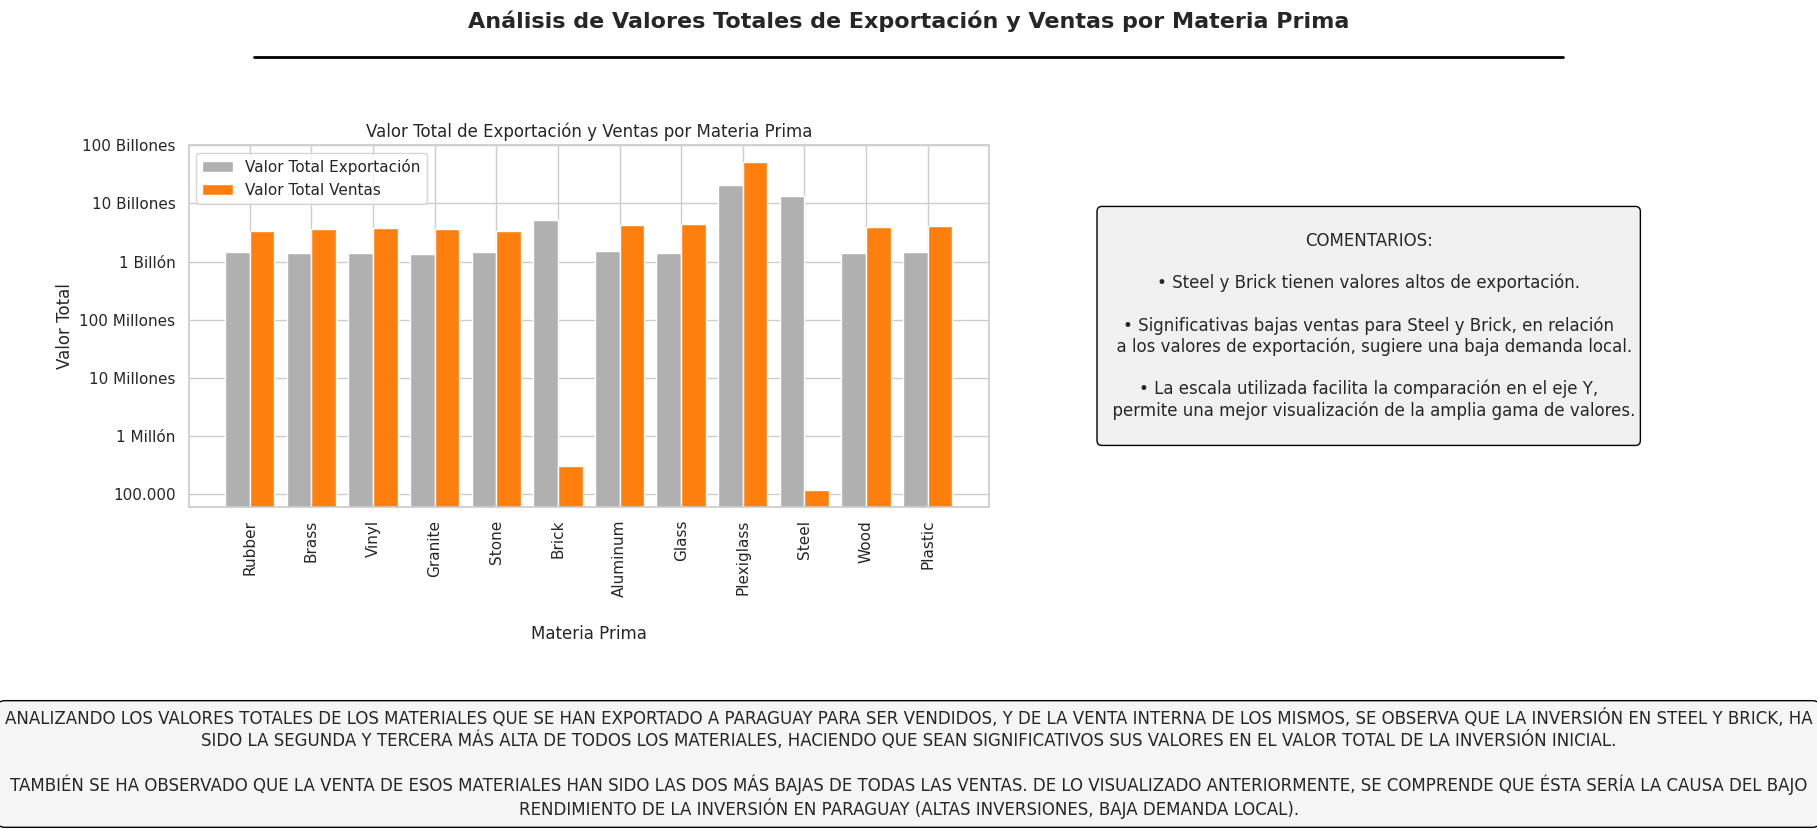

In [ ]:
# Configurar estilo de gráficos
sns.set(style="whitegrid")

# Crear la figura y los subplots
fig = plt.figure(figsize=(18, 14))  # Tamaño total de la figura ajustado
gs = fig.add_gridspec(4, 3, width_ratios=[3, 1, 0.5], height_ratios=[0.1, 1, 0.2, 0.25], wspace=0.3, hspace=0.5)

# Subplot para el comentario superior
ax_comment = fig.add_subplot(gs[0, :])
ax_comment.axis('off')  # Desactivar el eje
comentario_superior = "Análisis de Valores Totales de Exportación y Ventas por Materia Prima"
ax_comment.text(0.5, 0.5, comentario_superior, ha='center', va='center', fontsize=16, fontweight='bold')

# Añadir una línea horizontal para subrayar el comentario
ax_comment.plot([0.1, 0.9], [0.45, 0.45], color='black', lw=2)  # Línea horizontal para subrayar

# Subplot para el gráfico de barras
ax_bars = fig.add_subplot(gs[1, 0])
bar_width = 0.4  # Ancho de las barras
index = np.arange(len(total_df))

# Barras para el valor total de exportación
bar1 = ax_bars.bar(index - bar_width/2, total_df['total_exports'], bar_width, label='Valor Total Exportación', color='#b0b0b0')

# Barras para el valor total de ventas
bar2 = ax_bars.bar(index + bar_width/2, total_df['total_sales'], bar_width, label='Valor Total Ventas', color='#ff7f0e')

# Etiquetas y títulos
ax_bars.set_xlabel('Materia Prima', labelpad=20)  # Aumentar el espaciado entre la etiqueta y el eje
ax_bars.set_ylabel('Valor Total')
ax_bars.set_title('Valor Total de Exportación y Ventas por Materia Prima')
ax_bars.set_xticks(index)
ax_bars.set_xticklabels(total_df['material'], rotation=90)
ax_bars.set_yscale('log')  # Aplicar escala logarítmica al eje y

# Configurar ticks y etiquetas del eje Y
yticks = [1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11]
yticklabels = ['100.000', '1 Millón', '10 Millones', '100 Millones', '1 Billón', '10 Billones', '100 Billones']
ax_bars.set_yticks(yticks)
ax_bars.set_yticklabels(yticklabels)

ax_bars.legend()

# Subplot para los comentarios laterales
ax_comments = fig.add_subplot(gs[1, 1:])
ax_comments.axis('off')  # Desactivar el eje

# Comentarios en un bloque
comentarios_texto = (
    "\n"
    "COMENTARIOS:\n"
    "\n"
    "• Steel y Brick tienen valores altos de exportación.\n"
    "\n"
    "• Significativas bajas ventas para Steel y Brick, en relación\n"
    "  a los valores de exportación, sugiere una baja demanda local.\n"
    "\n"
    "• La escala utilizada facilita la comparación en el eje Y,\n"
    "  permite una mejor visualización de la amplia gama de valores.\n "
)

# Ajustar el tamaño del área de comentarios
ax_comments.text(0.5, 0.5, comentarios_texto, fontsize=12, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#f0f0f0'))

# Subplot para el comentario final centrado y ajustado
ax_final_comment = fig.add_subplot(gs[3, :])
ax_final_comment.axis('off')  # Desactivar el eje

# Comentario final
comentario_final = (
    "ANALIZANDO LOS VALORES TOTALES DE LOS MATERIALES QUE SE HAN EXPORTADO A PARAGUAY PARA SER VENDIDOS, Y DE LA VENTA INTERNA DE LOS MISMOS, "
    "SE OBSERVA QUE LA INVERSIÓN EN STEEL Y BRICK, HA SIDO LA SEGUNDA Y TERCERA MÁS ALTA DE TODOS LOS MATERIALES, HACIENDO QUE SEAN SIGNIFICATIVOS SUS VALORES EN EL VALOR TOTAL DE LA INVERSIÓN INICIAL.\n\n"
    "TAMBIÉN SE HA OBSERVADO QUE LA VENTA DE ESOS MATERIALES HAN SIDO LAS DOS MÁS BAJAS DE TODAS LAS VENTAS. "
    "DE LO VISUALIZADO ANTERIORMENTE, SE COMPRENDE QUE ÉSTA SERÍA LA CAUSA DEL BAJO RENDIMIENTO DE LA INVERSIÓN EN PARAGUAY (ALTAS INVERSIONES, BAJA DEMANDA LOCAL)."
)

# Ajustar el comentario final con un fondo gris claro y un ancho específico
ax_final_comment.text(0.5, 0.5, comentario_final, fontsize=12, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='#f5f5f5'), wrap=True)

# Ajustar el espaciado
fig.subplots_adjust(top=0.8, bottom=0.25, left=0.1, right=0.9, hspace=0.5, wspace=0.3)  # Ajustar top y bottom

# Mostrar el gráfico
plt.show()